In [12]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')

In [13]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
sns.set()
tf.compat.v1.random.set_random_seed(1234)

In [14]:
df = pd.read_csv('D:/Files/AMD.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-05-23,12.93,13.18,12.90,13.10,13.10,44388300
1,2018-05-24,13.06,13.43,13.03,13.41,13.41,47785700
2,2018-05-25,13.40,13.72,13.36,13.54,13.54,43850100
3,2018-05-29,13.45,13.63,13.26,13.36,13.36,39578500
4,2018-05-30,13.48,13.95,13.48,13.82,13.82,58186400


In [15]:
minmax = MinMaxScaler().fit(df.iloc[:, 4:5].astype('float32')) # Close index
df_log = minmax.transform(df.iloc[:, 4:5].astype('float32')) # Close index
df_log = pd.DataFrame(df_log)
df_log.head()

,0
0,0.000000
1,0.015800
2,0.022426
3,0.013252
4,0.036697


## Split train and test

I will cut the dataset to train and test datasets,

1. Train dataset derived from starting timestamp until last 30 days
2. Test dataset derived from last 30 days until end of the dataset

So we will let the model do forecasting based on last 30 days, and we will going to repeat the experiment for 10 times. You can increase it locally if you want, and tuning parameters will help you by a lot.

In [16]:
test_size = 30
simulation_size = 10

df_train = df_log.iloc[:-test_size]
df_test = df_log.iloc[-test_size:]
df.shape, df_train.shape, df_test.shape

((252, 7), (222, 1), (30, 1))

In [17]:
class Model:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)

        backward_rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        forward_rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop_backward = tf.contrib.rnn.DropoutWrapper(
            backward_rnn_cells, output_keep_prob = forget_bias
        )
        forward_backward = tf.contrib.rnn.DropoutWrapper(
            forward_rnn_cells, output_keep_prob = forget_bias
        )
        self.backward_hidden_layer = tf.placeholder(
            tf.float32, shape = (None, num_layers * 2 * size_layer)
        )
        self.forward_hidden_layer = tf.placeholder(
            tf.float32, shape = (None, num_layers * 2 * size_layer)
        )
        self.outputs, self.last_state = tf.nn.bidirectional_dynamic_rnn(
            forward_backward,
            drop_backward,
            self.X,
            initial_state_fw = self.forward_hidden_layer,
            initial_state_bw = self.backward_hidden_layer,
            dtype = tf.float32,
        )
        self.outputs = tf.concat(self.outputs, 2)
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )
        
def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
    return percentage * 100

def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

In [18]:
num_layers = 1
size_layer = 128
timestamp = 5
epoch = 300
dropout_rate = 0.8
future_day = test_size
learning_rate = 0.01

In [21]:
def forecast():
    learning_rate = 0.001
    num_layers = 2
    size_layer = 128
    dropout_rate = 0.8
    epoch = 100
    timestamp = 5
    test_size = 30  # Replace with your desired test size

    # Assuming df_train and df_log are your dataframes

    class Model(tf.keras.Model):
        def __init__(self, learning_rate, num_layers, input_dim, size, output_dim, dropout_rate):
            super(Model, self).__init__()
            self.X = tf.keras.layers.Input(shape=(None, input_dim))
            self.forward_hidden_layer = tf.keras.layers.LSTM(size, return_sequences=True, dropout=dropout_rate)
            self.backward_hidden_layer = tf.keras.layers.LSTM(size, return_sequences=True, go_backwards=True, dropout=dropout_rate)
            self.bi_lstm = tf.keras.layers.Bidirectional(self.forward_hidden_layer, backward_layer=self.backward_hidden_layer)(self.X)
            self.logits = tf.keras.layers.Dense(output_dim)(self.bi_lstm)

            self.optimizer = tf.optimizers.Adam(learning_rate=learning_rate)
            self.loss_fn = tf.losses.MeanSquaredError()

        def call(self, inputs, training=False):
            bi_lstm = self.bi_lstm(inputs, training=training)
            return self.logits(bi_lstm, training=training)

    modelnn = Model(learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate)

    date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()

    pbar = tqdm(range(epoch), desc='train loop')
    for i in pbar:
        init_value_forward = np.zeros((1, num_layers * 2 * size_layer))
        init_value_backward = np.zeros((1, num_layers * 2 * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(df_train.iloc[k:index, :].values, axis=0)
            batch_y = df_train.iloc[k + 1:index + 1, :].values
            with tf.GradientTape() as tape:
                logits = modelnn(batch_x, training=True)
                loss = modelnn.loss_fn(batch_y, logits)
            gradients = tape.gradient(loss, modelnn.trainable_variables)
            modelnn.optimizer.apply_gradients(zip(gradients, modelnn.trainable_variables))
            total_loss.append(loss.numpy())
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
        pbar.set_postfix(cost=np.mean(total_loss), acc=np.mean(total_acc))

    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value_forward = np.zeros((1, num_layers * 2 * size_layer))
    init_value_backward = np.zeros((1, num_layers * 2 * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        batch_x = np.expand_dims(df_train.iloc[k:k + timestamp].values, axis=0)
        out_logits = modelnn(batch_x)
        output_predict[k + 1:k + timestamp + 1] = out_logits

    if upper_b != df_train.shape[0]:
        batch_x = np.expand_dims(df_train.iloc[upper_b:].values, axis=0)
        out_logits = modelnn(batch_x)
        output_predict[upper_b + 1:df_train.shape[0] + 1] = out_logits
        future_day -= 1
        date_ori.append(date_ori[-1] + timedelta(days=1))

    init_value_forward = np.zeros((1, num_layers * 2 * size_layer))
    init_value_backward = np.zeros((1, num_layers * 2 * size_layer))

    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        batch_x = np.expand_dims(o, axis=0)
        out_logits = modelnn(batch_x)
        output_predict[-future_day + i] = out_logits[-1]
        date_ori.append(date_ori[-1] + timedelta(days=1))

    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)

    return deep_future[-test_size:]


In [22]:
results = []
for i in range(simulation_size):
    print('simulation %d'%(i + 1))
    results.append(forecast())  

simulation 1


train loop:   0%|          | 0/100 [00:00<?, ?it/s]


TypeError: Exception encountered when calling layer 'model_2' (type Model).

'KerasTensor' object is not callable

Call arguments received by layer 'model_2' (type Model):
  • inputs=tf.Tensor(shape=(1, 5, 1), dtype=float32)
  • training=True

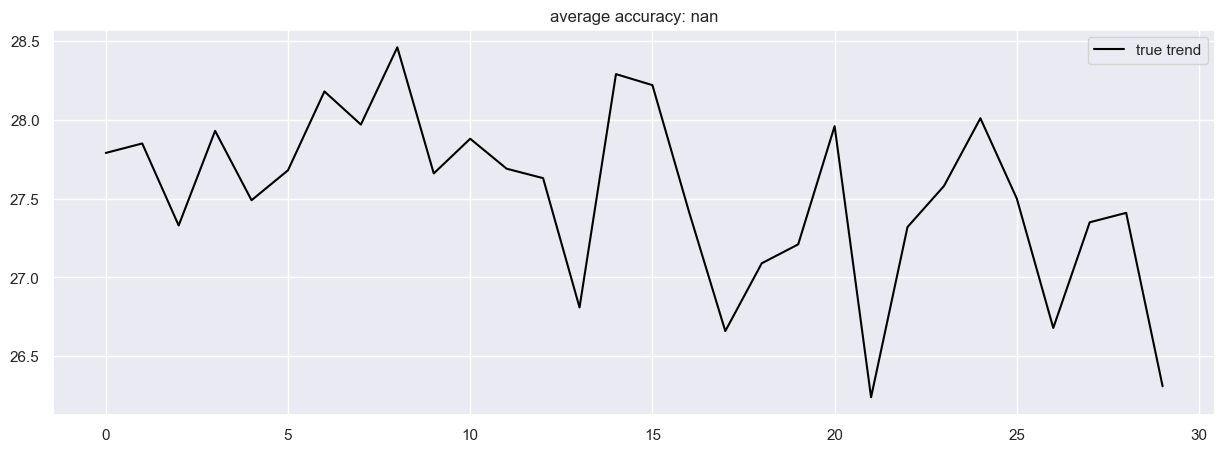

In [ ]:
accuracies = [calculate_accuracy(df['Close'].iloc[-test_size:].values, r) for r in results]

plt.figure(figsize = (15, 5))
for no, r in enumerate(results):
    plt.plot(r, label = 'forecast %d'%(no + 1))
plt.plot(df['Close'].iloc[-test_size:].values, label = 'true trend', c = 'black')
plt.legend()
plt.title('average accuracy: %.4f'%(np.mean(accuracies)))
plt.show()